# Test and visualize the driving scenarios

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, AutomotiveDrivingModels, AutoViz, Reel, Parameters, GridInterpolations

In [2]:
rng = MersenneTwister(1);

) in module Base at util.jl:532 overwritten in module Logging at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.

## Scenario 1: Single agent occluded crosswalk

Discrete environment, provides explicit transition and observation probability distributions. Support only one pedestrian

In [3]:
include("single_crosswalk/occluded_crosswalk_env.jl")
include("single_crosswalk/pomdp_types.jl")
include("single_crosswalk/spaces.jl")
include("single_crosswalk/transition.jl")
include("single_crosswalk/observation.jl")
include("single_crosswalk/belief.jl")
include("single_crosswalk/adm_helpers.jl")
include("single_crosswalk/render_helpers.jl")

 at C:\Users\Maxime\.julia\v0.6\Logging\src\Logging.jl:115.


In [4]:
pomdp = OCPOMDP()

OCPOMDP(CrosswalkEnv(Roadway, AutomotiveDrivingModels.Lane(LaneTag(2, 1), AutomotiveDrivingModels.CurvePt[CurvePt({25.000, -10.000, 1.571}, 0.000, 0.000, NaN), CurvePt({25.000, 10.000, 1.571}, 20.000, 0.000, NaN)], 6.0, AutomotiveDrivingModels.SpeedLimit(-Inf, Inf), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneBoundary(:unknown, :unknown), AutomotiveDrivingModels.LaneConnection[], AutomotiveDrivingModels.LaneConnection[]), AutomotiveDrivingModels.ConvexPolygon[ConvexPolygon: len 4 (max 4 pts)
	VecE2(15.000, -1.500)
	VecE2(15.000, -4.500)
	VecE2(21.500, -4.500)
	VecE2(21.500, -1.500)
], EnvParams(2, 50.0, 3.0, 20.0, 6.0, 5.0, 37.0, 8.0, 0.5, 2.0, 10.0)), VehicleDef(CAR, 4.000, 1.800), VehicleDef(PEDESTRIAN, 1.000, 1.000), 2.0, 1.0, 1.0, 5.0, -5.0, 37.0, 5.0, 0.5, 0.3, 0.3, false, 1.0, 1.0, 1.0, -1.0, 0.0, 1.0, 0.95)

In [5]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

**Simulate**

In [6]:
hr = HistoryRecorder(rng=rng)
hist = simulate(hr, pomdp, policy, up);

**Rendering**

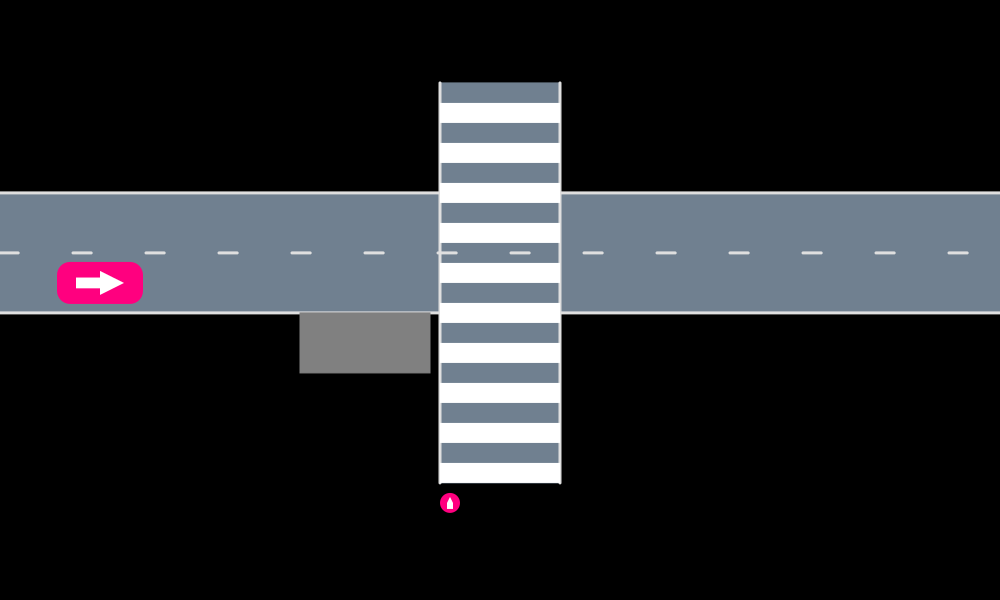

In [11]:
s = AutoViz.render(state_to_scene(pomdp,hist.state_hist[1]), pomdp.env, cam=FitToContentCamera(0.0))

In [ ]:
write_to_png()

In [23]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_DB0.tmp", 0x0000000000000023, 2.0, nothing)

## Scenario 2: Multi-agent Crosswalk 

Generative model for the occluded crosswalk scenario, support multiple pedestrians, continuous space

In [3]:
include("multi_crosswalk/occluded_crosswalk_env.jl")
include("multi_crosswalk/helpers.jl")
include("multi_crosswalk/pomdp_types.jl")
include("multi_crosswalk/constant_pedestrian.jl")
include("multi_crosswalk/generative_model.jl")
include("multi_crosswalk/render_helpers.jl")

LoadError: [91mcould not open file C:\Users\Maxime\OneDrive - Leland Stanford Junior University\Research\admscenarios\multi_crosswalk\helpers.jl[39m

In [4]:
pomdp = OCPOMDP();

LoadError: [91mUndefVarError: OCPOMDP not defined[39m

In [5]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

LoadError: [91mUndefVarError: pomdp not defined[39m

In [6]:
hr = HistoryRecorder(rng=rng, max_steps=100)
hist = simulate(hr, pomdp, policy, up);

LoadError: [91mUndefVarError: pomdp not defined[39m

In [ ]:
render()

In [15]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_4DE.tmp", 0x0000000000000006, 2.0, nothing)

## Scenario 3 : Single agent intersection

Explicit formulation with transition and observation probability distribution. Only support one vehicle

In [3]:
include("single_intersection/occluded_intersection_env.jl")
include("single_intersection/pomdp_types.jl")
include("single_intersection/spaces.jl")
include("single_intersection/transition.jl")
include("single_intersection/observation.jl")
include("single_intersection/belief.jl")
include("single_intersection/render_helpers.jl")

animate_hist (generic function with 1 method)

In [4]:
pomdp = OIPOMDP();

In [5]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [8]:
hr = HistoryRecorder(rng=rng, max_steps=100)
hist = simulate(hr, pomdp, policy, up);

In [9]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_263C.tmp", 0x0000000000000029, 2.0, nothing)

## Scenario 3: Multi-agent Intersection

Generative model for the occluded crosswalk scenario, support multiple pedestrians, continuous space

In [1]:
using POMDPs, StatsBase, POMDPToolbox, DeepRL, AutomotiveDrivingModels, AutoViz, Reel, Parameters, GridInterpolations

In [2]:
rng = MersenneTwister(1);

.

In [3]:
include("constants.jl")
include("utils/helpers.jl")
include("utils/occlusions.jl")

.


In [4]:
include("multi_intersection/occluded_intersection_env.jl")
include("multi_intersection/pomdp_types.jl")
include("multi_intersection/lane_keeper_idm.jl")
include("multi_intersection/generative_model.jl")
include("multi_intersection/render_helpers.jl")

animate_hist (generic function with 1 method)

 at C:\Users\Maxime\.julia\v0.6\AutomotiveDrivingModels\src\1d\drivers\intelligent_driver_models.jl:18 overwritten

In [5]:
pomdp = OIPOMDP();

 in module Main at C:\Users\Maxime\OneDrive - Leland Stanford Junior University\Research\admscenarios\multi_intersection\lane_keeper_idm.jl:37.


In [6]:
policy = solve(RandomSolver(rng), pomdp)
up = updater(policy);

In [7]:
hr = HistoryRecorder(rng=rng, max_steps=100)
hist = simulate(hr, pomdp, policy, up);

In [9]:
duration, fps, render_hist = animate_hist(pomdp, hist)
film = roll(render_hist, fps = fps, duration = duration)

Reel.Frames{MIME{Symbol("image/png")}}("C:\\Users\\Maxime\\AppData\\Local\\Temp\\jl_88D5.tmp", 0x0000000000000010, 2.0, nothing)

In [10]:
convert_o(Vector{Float64}, hist.observation_hist[end], pomdp)


44-element Array{Float64,1}:
  0.238891 
 -0.0459217
  1.29223  
  0.0      
  0.466667 
 -0.166667 
  0.5      
  0.0      
  0.466667 
 -0.166667 
  0.5      
  0.0      
  0.466667 
  ⋮        
  0.466667 
 -0.166667 
  0.5      
  0.0      
  0.466667 
 -0.166667 
  0.5      
  0.0      
  0.466667 
 -0.166667 
  0.5      
  0.0      

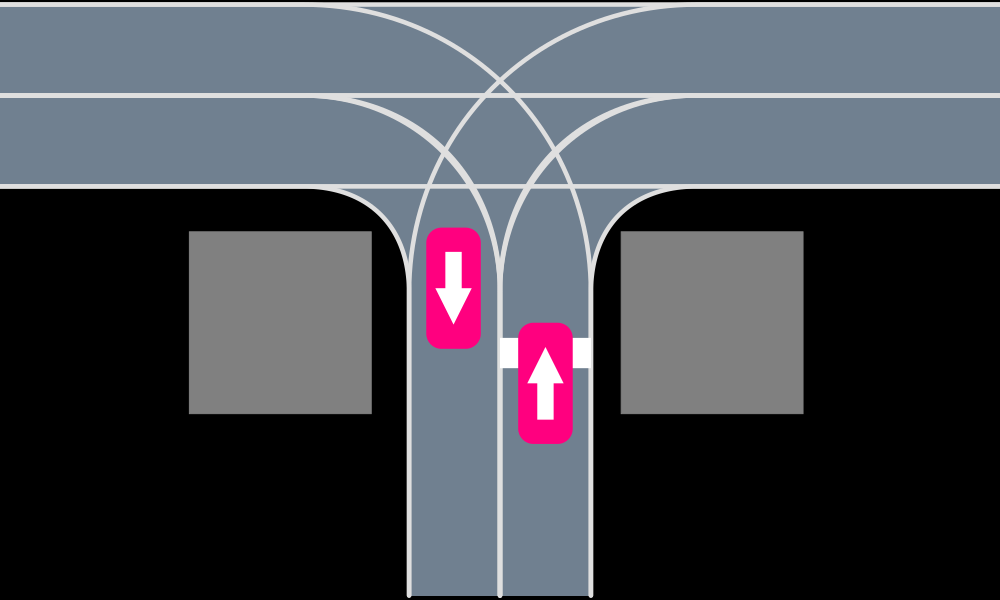

In [11]:
s = obs_to_scene(pomdp, hist.observation_hist[2])
AutoViz.render(s, pomdp.env, cam=FitToContentCamera(0.))




In [18]:
s = rand(hist.state_hist)
for veh in s 
    println(veh)
end  
    
    

Vehicle(1, VehicleState(VecSE2({8.000, -5.500}, 1.571), Frenet(RoadIndex({1, 0.950000}, {6, 1}), 9.500, 0.000, 0.000), 2.000), VehicleDef(CAR, 4.000, 1.800))
Vehicle(5, VehicleState(VecSE2({9.068, 2.006}, -2.638), Frenet(RoadIndex({18, 0.004076}, {3, 1}), 14.099, 0.000, 0.000), 6.865), VehicleDef(CAR, 4.000, 1.800))
Vehicle(6, VehicleState(VecSE2({-1.125, 0.000}, 0.000), Frenet(RoadIndex({1, 0.887500}, {4, 1}), 8.875, 0.000, 0.000), 5.500), VehicleDef(CAR, 4.000, 1.800))
Vehicle(7, VehicleState(VecSE2({-8.625, 0.000}, 0.000), Frenet(RoadIndex({1, 0.137500}, {4, 1}), 1.375, 0.000, 0.000), 0.500), VehicleDef(CAR, 4.000, 1.800))


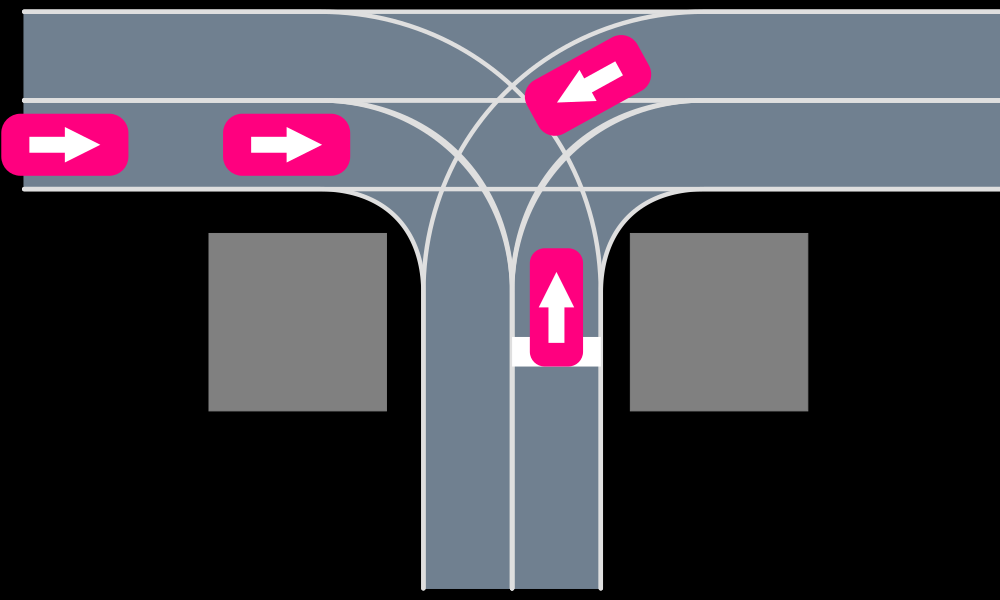

In [19]:
AutoViz.render(s, pomdp.env, cam=FitToContentCamera(0.))

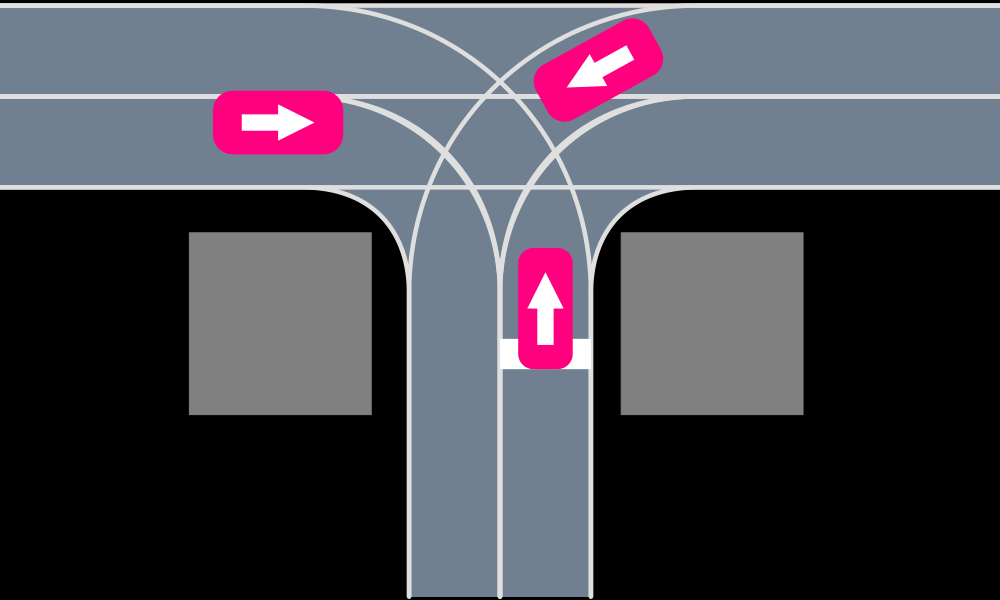

In [20]:
o = generate_o(pomdp, s, rng)
s_ = obs_to_scene(pomdp, o)
AutoViz.render(s_, pomdp.env, cam=FitToContentCamera(0.0))